# Numerical Integration

In [62]:
%matplotlib inline
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

import tellurium as te
import gene_network as gn
import modeling_game as mg
import model_fitting as mf
import util

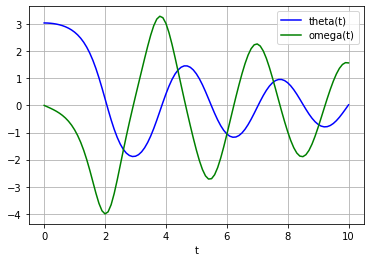

In [3]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 10, 101)
sol = odeint(pend, y0, t, args=(b, c))

plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

## lmfit and numerical integration

In [7]:
df_mrna = mf.cleanColumns(pd.read_csv("wild.csv"))
df_mrna.head()

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
time,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.099307,0.020844,0.007720,0.781444,0.013691,0.084857,2.404909,0.746052
20.0,0.129347,0.041853,0.007983,0.781449,0.014414,1.000481,2.361672,0.688322
30.0,0.241193,0.088704,0.055608,0.781449,0.065749,1.286064,2.248185,0.621902
40.0,0.436952,0.153115,0.357630,0.781445,0.282754,1.326094,2.102741,0.566512


In [59]:
initializations = util.readFile("model_initializations.txt")

namespace = {}
parameters = mg.makeParameters(['Vm7', 'K1_7', 'K2_7', 'K3_7', 'H7'])
valuesdict = parameters.valuesdict()
for name, value in valuesdict.items():
    namespace[name] = value

exec(initializations, namespace)

kinetics_mrna = '''
L7 - d_mRNA7*mRNA7 + Vm7 * ( K2_7*P4^H7 ) / ( 1 + K1_7*P7^H7 + K2_7*P4^H7 + K3_7*P7^H7*P4^H7)
'''
kinetics_mrna = kinetics_mrna.replace("^", "**")
kinetics_protein = "a_protein%d*mRNA%d - d_protein%d*P%d;"
kinetics_protein = kinetics_protein.replace(";", "")

eval(kinetics_mrna, namespace)

0.0178636133026099

In [70]:
ngene = 7

In [114]:
def calcKinetics(y, time):
    """
    y[0] = mRNA, y[1],...,y[8] = P1...P8
    # outer scoped: , ngene, df_mrna, kinetics_mrna, kinetics_protein, namespace
    """
    # Adjust time
    time = 10*round(time/10)
    # Update the namespae 
    for idx in range(1, 8):
        protein = "P%d" % idx
        namespace[protein] = y[idx]
        col = "mRNA%d" % idx
        namespace[col] = df_mrna.loc[time, col]
    mRNA = "mRNA%d" % ngene
    namespace[mRNA] = y[0]
    # Calculate the drivatives
    dydt = [eval(kinetics_mrna, namespace)]
    for idx in range(1, 9):
        statement = kinetics_protein % (idx, idx, idx, idx)
        dydt.append(eval(statement, namespace))
    return dydt

In [61]:
calcKinetics(np.repeat(0,9), 10.0, 7, df_mrna, kinetics_mrna, kinetics_protein, namespace)

[-1.470080903031201,
 0.008848796300155781,
 0.0017198821132135378,
 0.0009161431000014355,
 0.06743577961581705,
 0.001455210339109492,
 0.007556787671052411,
 0.18377587174475157,
 0.0]

In [115]:
# Do the integration
y0 = np.repeat(0, gn.NUM_GENE + 1)
t = np.array(df_mrna.index.tolist())
sol = odeint(calcKinetics, y0, t)


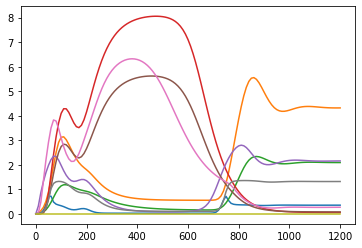

In [117]:
plt.plot(t, sol)

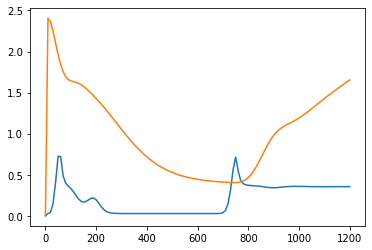

In [118]:
plt.plot(t, sol[:,0], t, df_mrna["mRNA7"])

In [100]:
namespace["mRNA7"]

1.6551702409686848

In [101]:
eval("L7 - d_mRNA7*mRNA7", namespace)

-1.0062091343479602

In [103]:
statement = "Vm7 * ( K2_7*P4**H7 ) / ( 1 + K1_7*P7**H7 + K2_7*P4**H7 + K3_7*P7**H7*P4**H7)"
eval(statement, namespace)

0.00019651153866496202

In [104]:
namespace["mRNA7"]

1.6551702409686848

In [97]:
# Not getting correct value for mRNA7
sol[:, 0]

array([   0.        ,   -7.26101372,  -21.80985607,  -35.86171228,
        -49.13118067,  -61.52141073,  -73.11280956,  -84.06343073,
        -94.55255935, -104.74932472, -114.78602406, -124.74168715,
       -134.64428475, -144.48615678, -154.2416525 , -163.88030674,
       -173.37433488, -182.70187074, -191.84759555, -200.80175946,
       -209.55811031, -218.11137474, -226.45533357, -234.5823401 ,
       -242.48414389, -250.15312781, -257.58323353, -264.77041345,
       -271.7126824 , -278.40993957, -284.86374178, -291.07707859,
       -297.05418068, -302.80038771, -308.32201272, -313.62622701,
       -318.72095109, -323.61472433, -328.31658986, -332.83596309,
       -337.18251761, -341.36604145, -345.39634341, -349.28313443,
       -353.03593744, -356.66401203, -360.17628573, -363.5813055 ,
       -366.88720454, -370.10167098, -373.23194287, -376.28479934,
       -379.26656473, -382.18312116, -385.03992205, -387.84200989,
       -390.5940372 , -393.30028862, -395.96470259, -398.59089